In [23]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures


In [8]:
# Importar pickle con el dataset preprocesado
df = pd.read_pickle('DatasetFinalParaEntrenar.pkl')

### Fit & Transform

In [9]:
# Separar Variables por tipo
categoricals = ['property_type','place_name','state_name','zona']
descriptions = ['texto']
numericals = ['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms', 'expenses','lat','lon']
dummies = ['subte','colectivo','balcon','tren','porton','financia', 'parrilla','pileta', 'solarium', 'lavadero', 'estacionamiento', 'no_apto_credito','apto_credito', 'amplioliving', 'cocheras', 'frente', 'contrafrente','seguridad', 'amenities', 'SUM', 'espaciosverdes','jacuzzi','estrenar','aptoprofesional','pozo','categoria','reciclado','luminoso','acondicionado','quincho','escalera']
target = ['price_usd_per_m2']

In [22]:
# Analyzar DEGREES de posibles polynomial features para una regresión lineal
from sklearn.pipeline import make_pipeline
#vectorizer = TfidfVectorizer(min_df=5)
#enc = DictVectorizer()
#clf = LinearRegression(fit_intercept=True)
#normalizer = preprocessing.Normalizer()
#poly = PolynomialFeatures(degree), include_bias = False)

def PolynomialRegression(degree=4, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(fit_intercept=True,n_jobs=-1,**kwargs))

from sklearn.model_selection import validation_curve
grados_a_testear = np.arange(0, 9)
train_score, val_score = validation_curve(PolynomialRegression(), df[numericals], Ydf, 'polynomialfeatures__degree'
                                          , grados_a_testear, cv=10) #cv= validacion cruzada, cuanta cantidad quiero


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.21211393 0.21001041 0.21081992 0.20577614 0.20962305 0.21234968
  0.2117226  0.2183311  0.21375255 0.20432098]
 [0.30011578 0.29899187 0.30096051 0.29235834 0.29639803 0.29921609
  0.29874804 0.29979044 0.30334968 0.29158386]]
[[-1.72927606e-02 -2.13082605e-02 -5.12597618e-03 -6.85153401e-03
  -8.14488694e-04 -1.49136775e-05 -3.67340465e-02 -3.29047455e-02
  -1.76501696e-03 -7.70378039e-03]
 [ 1.75088824e-01  1.94051266e-01  2.01667813e-01  2.46377738e-01
   2.14502307e-01  1.84636055e-01  1.65049318e-01 -9.58684362e-03
   1.68349061e-01  2.59203486e-01]
 [ 2.60130300e-01  2.35990255e-01  2.70889309e-01  3.42791147e-01
   2.85864738e-01  2.80895773e-01  2.62774478e-01 -3.44689772e-01
   2.31526873e-01  3.49461252e-01]]


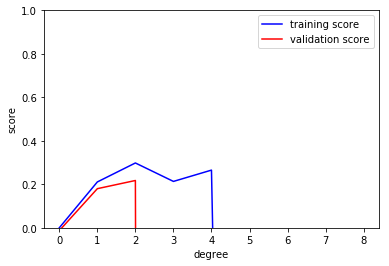

In [24]:
# Graficar curva
print(train_score[:3])
print(val_score[:3])

plt.plot(grados_a_testear, np.mean(train_score, axis=1), color='blue', label='training score')
plt.plot(grados_a_testear, np.mean(val_score, axis=1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

In [25]:
# Separar Train-Test

Xdf = df[np.concatenate([
        categoricals,
        descriptions,
        numericals,
        dummies
])]
Ydf = df[target]

X_trainDf, X_testDf, y_trainDf, y_testDf = train_test_split(Xdf, Ydf, test_size=0.30)

In [26]:
# FIT (función) - Vectorizar categóricas, Vectorizar texto en Description y Normalizar continuas
vectorizer = TfidfVectorizer(min_df=5)
enc = DictVectorizer()
clf = LinearRegression(fit_intercept=True,n_jobs=-1)
normalizer = preprocessing.Normalizer()
poly = PolynomialFeatures(degree = 1, include_bias = False)

def fit_model(X_train, Y_train):
    texts = X_train[descriptions]
    texts = texts.applymap(lambda x: x.lower())
    texts = texts.replace('[^a-zA-Z0-9]', ' ', regex = True)

    X_tfidf = vectorizer.fit_transform(texts[descriptions[0]])
    
    X_train_categ = enc.fit_transform(X_train[categoricals].to_dict('records'))
    
    X_numericas = poly.fit_transform(normalizer.fit_transform(X_train[numericals]))
    
    X_dummies = X_train[dummies]

    X = hstack([X_tfidf, X_train_categ, X_numericas, X_dummies]) # regualirzar las numericas luego de splitear
    
    # train model on data
    clf.fit(X, Y_train)
    return X, Y_train

X__train, y__train = fit_model(X_trainDf, y_trainDf)

In [27]:
# TRANSFORM (función)
def transform_model(X_train):
    texts = X_train[descriptions]
    texts = texts.applymap(lambda x: x.lower())
    texts = texts.replace('[^a-zA-Z0-9]', ' ', regex = True)

    X_tfidf = vectorizer.transform(texts[descriptions[0]])
    
    X_train_categ = enc.transform(X_train[categoricals].to_dict('records'))
    
    X_numericas = poly.transform(normalizer.transform(X_train[numericals]))
    
    X_dummies = X_train[dummies]

    X = hstack([X_tfidf, X_train_categ, X_numericas, X_dummies])
    
    return X
X__test = transform_model(X_testDf)
X__test

<26910x21981 sparse matrix of type '<class 'numpy.float64'>'
	with 2153646 stored elements in COOrdinate format>

In [28]:
# Métricas
from sklearn import metrics
print ('Score de Entrenamiento: ',clf.score(X__train, y__train))
print ('Score de Test: ',clf.score(X__test, y_testDf))
print ('MAE: ', metrics.mean_absolute_error(y_testDf, clf.predict(X__test)))
print ('MSE: ', metrics.mean_squared_error(y_testDf, clf.predict(X__test)))
print ('RMSE: ', np.sqrt(metrics.mean_squared_error(y_testDf, clf.predict(X__test))))
print ('R2: ', metrics.r2_score(y_testDf, clf.predict(X__test)))

Score de Entrenamiento:  0.8615408971250876
Score de Test:  0.5161040948823841
MAE:  398.16659930363534
MSE:  417246.8499607679
RMSE:  645.9464760804628
R2:  0.5161040948823841


In [29]:
# Ejemplo
print(clf.predict(X__test)[100][0])
print(y_testDf.iloc[100,0])

1355.5373251973263
1453.4883720930234
